In [4]:
import time
import numpy as np
import h5py
import hdf5plugin
import pandas as pd
import matplotlib as mpl
import matplotlib.colors as cm
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from unyt import yr, Myr, kpc, arcsec, nJy, Mpc, Msun, erg, s, Hz
from astropy.cosmology import Planck18 as cosmo
from scipy import signal

from synthesizer.grid import Grid
from synthesizer.parametric import SFH, ZDist
from synthesizer.particle.stars import sample_sfhz
from synthesizer.parametric import Stars as ParametricStars
from synthesizer.particle.particles import CoordinateGenerator
from synthesizer.filters import Filter, FilterCollection

from synthesizer.load_data.load_camels import load_CAMELS_IllustrisTNG
from synthesizer.kernel_functions import Kernel

from synthesizer.conversions import lnu_to_absolute_mag

/var/folders/yn/_ch1_n7x7y1g91hrx1ljp5n80000gp/T/ipykernel_41998/3608529151.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [5]:
# get grid
grid_name = "bc03-2016-Miles_chabrier-0.1,100.hdf5"
grid_dir = "/Users/am/Documents/CAMELS/data/grids"
grid = Grid(grid_name, grid_dir=grid_dir, read_lines=False)
print(grid)

------------------------------
SUMMARY OF GRID
log10age: [ 5.          5.          5.14998846  5.20000187  5.25000503  5.3000082
  5.3499959   5.40000235  5.45000263  5.50000307  5.55000809  5.60000309
  5.65000623  5.7000024   5.74999898  5.80000183  5.85000259  5.90000097
  5.95000442  6.          6.01998816  6.04000864  6.06001754  6.08001285
  6.09999123  6.12001425  6.14000495  6.15998805  6.18001112  6.20000187
  6.22000343  6.23999979  6.2599998   6.28000895  6.3000082   6.3200008
  6.34000762  6.36000613  6.37999404  6.40000235  6.42000528  6.43999547
  6.45999526  6.48000694  6.50000307  6.51999853  6.54000394  6.56000233
  6.58000069  6.60000309  6.62000064  6.64000415  6.66000172  6.67999992
  6.7000024   6.7200021   6.73999931  6.76000005  6.7800003   6.80000183
  6.81999773  6.83999939  6.86000242  6.88000139  6.90000097  6.91999803
  6.93999821  6.9599996   6.97999882  7.          7.01998816  7.04000864
  7.06001754  7.08001285  7.09999123  7.11998131  7.14000495  7.15998

In [9]:
# get gals
gals_033 = load_CAMELS_IllustrisTNG(
    "/Users/am/Documents/CAMELS/data/CV/CV_0",
    snap_name="snap_033.hdf5",
    fof_name="fof_subhalo_tab_033.hdf5",
)

print('Number of Galaxies in snap_033', len(gals_033))


cat_033 = '/Users/am/Documents/CAMELS/data/CV/CV_0/fof_subhalo_tab_033.hdf5'
# open file
f = h5py.File(cat_033, 'r')

# read different attributes of the header
BoxSize_033      = f['Header'].attrs[u'BoxSize']/1e3 #Mpc/h
redshift_033    = f['Header'].attrs[u'Redshift']
print('BoxSize: ', BoxSize_033)
print('redshift: ', redshift_033)
# so z=0
redshift_033 = 0

Number of Galaxies in snap_033 17176
BoxSize:  25.0
redshift:  2.220446049250313e-16


In [10]:
# Lets work with z=0 so gals_033
gal = gals_033[0]
#to get the full SED from a galaxy you need to run something like this
spec = gal.stars.get_spectra_incident(grid)

spec.lnu # rest frame lumd



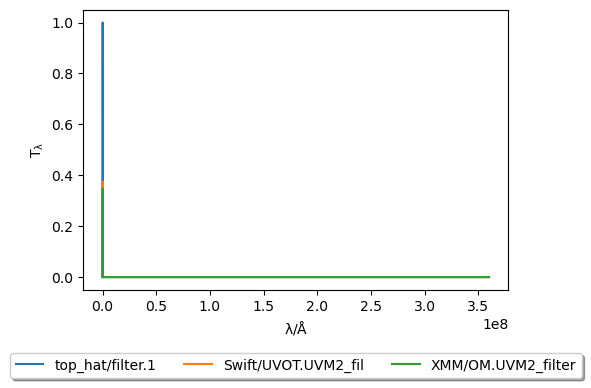

In [19]:
# Need to use the grid lam, dont need to define wavelengths here: see codes here: http://svo2.cab.inta-csic.es/theory/fps/index.php?id=Swift/UVOT.UVM2&&mode=browse&gname=Swift&gname2=UVOT#filter
# need to use transmission NOT area
# Get for XMM
fil_uvm2_XMM = Filter("XMM/OM.UVM2_filter", new_lam=grid.lam)

# now get for UVOT
fil_uvm2_UVOT = Filter("Swift/UVOT.UVM2_fil", new_lam=grid.lam) # changed from new_lam=lams_uvot to grid.lam and get 0 transmission, but warning sign is back

# what is a top hat filter?
filt1 = Filter("top_hat/filter.1", lam_min=1400, lam_max=1600, new_lam=grid.lam)

filt_lst = [filt1, fil_uvm2_UVOT, fil_uvm2_XMM]

combined_filters = FilterCollection(
    filters=filt_lst, new_lam=grid.lam
)

fig, ax= combined_filters.plot_transmission_curves(show=True) # log this.
# cant figure out how to log lot this but logged would show the curves better.

In [20]:
spec.get_photo_luminosities(combined_filters)
spec.photo_luminosities.photo_luminosities
# dont need to do redshift corrections as we do K-corrections in our observational paper, which basically gets rid of the effects of the expansion of the universe 
# so we dont need to account for objects being further away as being redder/bluer as this is acocunted for/removed in the observational project so we don't need to add
# it back in here to make like for like.

In [24]:
lnu_to_absolute_mag(spec.photo_luminosities.photo_luminosities)

array([-16.93728855, -18.25471661, -18.32084028])

In [ ]:
# filter, magnitude, plot lumi function.
# Need to ask mat about the filter. are we loooking at rest frame magnitudes or observed frame magnitudes.
# From paper, if M_{1500} is the centre of the absolute magnitude bin in the rest frame UV band and bins are 0.5mag wide (first, what does this even mean) and how do we like
# for like this in our simulation.

In [ ]:
# To do :
# need to apply to all galaxies in the snap/subhalo catalogue
# once I've done that, can use the combine_list_of_seds to combine all of them and then apply the filter and get the luminosities from this.
# crate a list of the sed objects, then can 
from synthesizer.sed import combine_list_of_seds

# run this on lsit of seds and gets a single sed objects that contain all my luminosities.
# then can apply photometry and lnu to abs mag.